In [197]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from time import time
import math
import random

import os
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer #count vectorizer
from sklearn.model_selection import train_test_split #train est split

from sklearn.pipeline import Pipeline #import the pipeline
from sklearn.feature_extraction.text import TfidfVectorizer #import Tf idf Vectorizer

from sklearn.linear_model import LogisticRegression #logistic regression 
from sklearn.svm import LinearSVC #logistic regression 

from sklearn.metrics import classification_report, plot_confusion_matrix #classification report

%matplotlib inline 

In [216]:
#
review_order = []

with open('aclImdb/imdb.vocab') as f:
    vocab = [word.rstrip() for word in f]
    # Keep only most frequent 5000 words rather than all 90000
    # Just saving memory - the long tail occurs too few times
    # for the model to learn anything anyway
    vocab = vocab[:5000]
    print('%d words in vocabulary' % (len(vocab),))

def text_tokens(text):
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    tokens = text.split(' ')
    return tokens

def load_dataset(dirname):
    X, y = [], []
    # Review files: neg/0_3.txt neg/10000_4.txt neg/10001_4.txt ...
    for y_val, y_label in enumerate(['neg', 'pos']):
        y_dir = os.path.join(dirname, y_label)
        for fname in os.listdir(y_dir):
            review_order.append(fname)
            fpath = os.path.join(y_dir, fname)
            # print('\r' + fpath + '   ', end='')
            with open(fpath) as f:
                tokens = text_tokens(f.read())
            X.append(tokens)
            y.append(y_val)  # 0 for 'neg', 1 for 'pos'
#     print()
    return X, y



5000 words in vocabulary


In [199]:
X_train, y_train = load_dataset('aclImdb/train/')
X_val, y_val = load_dataset('aclImdb/test/')

In [200]:
def bow_onehot_vector(tokens):
    vector = [0] * len(vocab)
    for t in tokens:
        try:
            vector[vocab.index(t)] = 1
        except:
            pass  # ignore missing words
    return vector

In [201]:
from tqdm import tqdm

X_bow_train = [bow_onehot_vector(x) for x in tqdm(X_train)]
X_bow_val = [bow_onehot_vector(x) for x in tqdm(X_val)]

100%|██████████| 25000/25000 [01:14<00:00, 334.70it/s]


In [202]:
def best_train_history(history):
    best_epoch = np.argmax(history.history['val_accuracy'])
    print('Accuracy (epoch %d): %.4f train, %.4f val' % \
          (best_epoch + 1, history.history['accuracy'][best_epoch], history.history['val_accuracy'][best_epoch]))


In [203]:
from keras.layers import Activation, Dense, Input
from keras.models import Model

# print(typ)

class BOWSentimentModel(object):
    def __init__(self):
        bow = Input(shape=(len(vocab),), name='bow_input')
        # weights of all inputs
        sentiment = Dense(1)(bow)
        # normalize to [0, 1] range
        sentiment = Activation('sigmoid')(sentiment)

        self.model = Model(inputs=[bow], outputs=[sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), np.array(y), validation_data=(np.array(X_val), np.array(y_val)), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = BOWSentimentModel()
history = sentiment.train(X_bow_train, y_train, X_bow_val, y_val)
best_train_history(history)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bow_input (InputLayer)      [(None, 5000)]            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5001      
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
Fitting...
Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 0.4584 - accuracy: 0.8267 - val_loss: 0.3661 - val_accuracy: 0.8699
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 0.3149 - accuracy: 0.8879 - val_loss: 0.3183 - val_accuracy: 0.8787
Epoch 3/10
782/782 [======

In [204]:
print()

In [205]:
test_text = 'Good story about a backwoods community in the Ozarks around the turn of the century. Moonshine is the leading industry, fighting and funning the major form of entertainment. One day a stranger enters the community and causes a shake-up among the locals. Beautiful scenery adds much to the story.'
test_tokens = text_tokens(test_text)
print(test_text)
print(sentiment.predict([bow_onehot_vector(test_tokens)])[0])


Good story about a backwoods community in the Ozarks around the turn of the century. Moonshine is the leading industry, fighting and funning the major form of entertainment. One day a stranger enters the community and causes a shake-up among the locals. Beautiful scenery adds much to the story.
[0.745326]


In [206]:
test_text = 'Boring story about a backwoods community in the Ozarks around the turn of the century. Moonshine is the leading industry, fighting and funning the major form of entertainment. One day a stranger enters the community and causes a shake-up among the locals. Beautiful scenery does not add to the story.'
test_tokens = text_tokens(test_text)
print(test_text)
print(sentiment.predict([bow_onehot_vector(test_tokens)])[0])

Boring story about a backwoods community in the Ozarks around the turn of the century. Moonshine is the leading industry, fighting and funning the major form of entertainment. One day a stranger enters the community and causes a shake-up among the locals. Beautiful scenery does not add to the story.
[0.36729568]


In [207]:
def plot_train_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

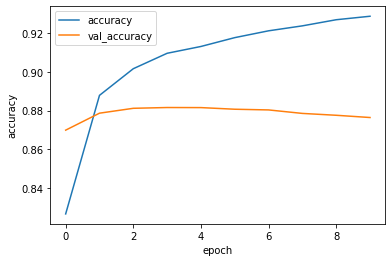

In [208]:
plot_train_history(history)

In [209]:
# path = "C://Users//tobysavage//"
path = 'aclImdb/test/neg'
dir_list = os.listdir(path)
print(dir_list.index('0_2.txt'))
print(dir_list[7387])
# dir_list.sort()
# print(dir_list)
print(len(dir_list))


7387
0_2.txt
12500


In [210]:
# print(review_order[0:5])
# print(len(review_order))
# print(len(X_train))
# print(review_order[24998:25005])
# print(review_order[24999])

# train
neg_train_files = review_order[0:12500]
pos_train_files = review_order[12500:25000]

# test
neg_test_files = review_order[25000:37500]
pos_test_files = review_order[37500:]

# print(review_order[12498:12502])
# print(review_order[24998:25002])

# print(pos_train_files[12499])
# print(X_train[12499])
# print(len(X_train))

neg_train_counts = []

neg_d = {}
# i = X_train[0]
for i in range(0, 12500):
    for j in X_train[i]:
        if j not in neg_d.keys():
            neg_d[j] = 0
        neg_d[j]+=1
        
pos_d = {}
i = X_train[0]
for i in range(12500, 25000):
    for j in X_train[i]:
        if j not in pos_d.keys():
            pos_d[j] = 0
        pos_d[j]+=1

    
# print(neg_d)

pos_list = sorted([(key, value) for key, value in zip(pos_d.keys(), pos_d.values())], key = lambda x: -x[1])
neg_list = sorted([(key, value) for key, value in zip(neg_d.keys(), neg_d.values())], key = lambda x: -x[1])

# 1. Negtive reviews
# count_vect = CountVectorizer(stop_words = 'english')
# matrix = count_vect.fit_transform(X_train[0:12500])
# freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
# #print sorted words 
# print(sorted(freqs, key = lambda x: -x[1])[:20])            

In [291]:
# RUN FROM HERE

import os

#################################

directory = './aclImdb/train/pos'

pos_reviews = []
pos_sentiment = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = open(f, "r")
    x = [i for i in text]
    pos_reviews.append(x)
    pos_sentiment.append('positive')
    text.close()
    
#################################

directory = './aclImdb/train/neg'

neg_reviews = []
neg_sentiment = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = open(f, "r")
    x = [i for i in text]
    neg_reviews.append(x)
    neg_sentiment.append('negative')
    text.close()
    
#################################
    

In [292]:
pos_df = pd.DataFrame(pos_reviews, columns = ['review'])
pos_df.insert(1, "sentiment", pos_sentiment)

In [293]:
neg_df = pd.DataFrame(neg_reviews, columns = ['review'])
neg_df.insert(1, "sentiment", neg_sentiment)

In [294]:
df = pd.concat([pos_df, neg_df], ignore_index = True)

In [295]:
# Data Cleaning
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext
df['review'] = df['review'].apply(lambda x: cleanhtml(x))

In [296]:
# Positive reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df[df.sentiment == 'positive']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20])            

[('film', 20933), ('movie', 19074), ('like', 9036), ('good', 7721), ('just', 7152), ('story', 6778), ('time', 6515), ('great', 6418), ('really', 5473), ('people', 4479), ('best', 4320), ('love', 4302), ('life', 4201), ('way', 4037), ('films', 3811), ('think', 3654), ('movies', 3582), ('characters', 3557), ('character', 3516), ('don', 3482)]


In [297]:
# Negative reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df[df.sentiment == 'negative']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20])  

[('movie', 24955), ('film', 19211), ('like', 11238), ('just', 10613), ('good', 7419), ('bad', 7394), ('really', 6262), ('time', 6208), ('don', 5361), ('story', 5203), ('people', 4806), ('make', 4719), ('plot', 4152), ('movies', 4081), ('acting', 4055), ('way', 3989), ('think', 3641), ('characters', 3597), ('watch', 3547), ('character', 3507)]


In [298]:
X = df['review']
y = df['sentiment']

In [299]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [300]:
# create the pipline 
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('svc', LinearSVC())])

# fit the pipeline  
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      2485
    positive       0.87      0.90      0.89      2515

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



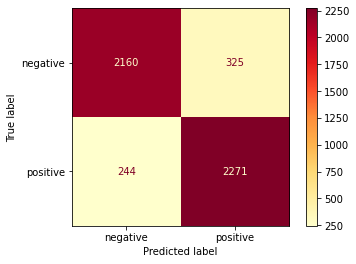

In [301]:
# create the classification report and plot the confusion matrix
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(pipe, X_test, y_test, cmap = "YlOrRd")

In [302]:
# RUN FROM HERE

import os

#################################

directory = './aclImdb/test/pos'

pos_reviews_test = []
pos_sentiment_test = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = open(f, "r")
    x = [i for i in text]
    pos_reviews_test.append(x)
    pos_sentiment_test.append('positive')
    text.close()
    
#################################

directory = './aclImdb/test/neg'

neg_reviews_test = []
neg_sentiment_test = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = open(f, "r")
    x = [i for i in text]
    neg_reviews_test.append(x)
    neg_sentiment_test.append('negative')
    text.close()
    
#################################

In [303]:
pos_df_test = pd.DataFrame(pos_reviews, columns = ['review'])
pos_df_test.insert(1, "sentiment", pos_sentiment)

In [304]:
neg_df_test = pd.DataFrame(neg_reviews, columns = ['review'])
neg_df_test.insert(1, "sentiment", neg_sentiment)

In [305]:
df_test = pd.concat([pos_df_test, neg_df_test], ignore_index = True)

In [306]:
# Data Cleaning
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext
df_test['review'] = df_test['review'].apply(lambda x: cleanhtml(x))

In [307]:
# Positive reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df_test[df_test.sentiment == 'positive']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20]) 

[('film', 20933), ('movie', 19074), ('like', 9036), ('good', 7721), ('just', 7152), ('story', 6778), ('time', 6515), ('great', 6418), ('really', 5473), ('people', 4479), ('best', 4320), ('love', 4302), ('life', 4201), ('way', 4037), ('films', 3811), ('think', 3654), ('movies', 3582), ('characters', 3557), ('character', 3516), ('don', 3482)]


In [308]:
# Negative reviews
count_vect = CountVectorizer(stop_words = 'english')
matrix = count_vect.fit_transform(df_test[df_test.sentiment == 'negative']['review'])
freqs = zip(count_vect.get_feature_names(), matrix.sum(axis = 0).tolist()[0])
#print sorted words 
print(sorted(freqs, key = lambda x: -x[1])[:20])  

[('movie', 24955), ('film', 19211), ('like', 11238), ('just', 10613), ('good', 7419), ('bad', 7394), ('really', 6262), ('time', 6208), ('don', 5361), ('story', 5203), ('people', 4806), ('make', 4719), ('plot', 4152), ('movies', 4081), ('acting', 4055), ('way', 3989), ('think', 3641), ('characters', 3597), ('watch', 3547), ('character', 3507)]


In [309]:
X_test = df_test['review']
y_test = df_test['sentiment']

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97     12500
    positive       0.97      0.97      0.97     12500

    accuracy                           0.97     25000
   macro avg       0.97      0.97      0.97     25000
weighted avg       0.97      0.97      0.97     25000



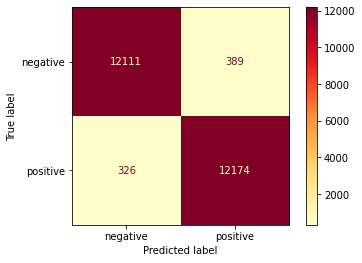

In [310]:
# create the classification report and plot the confusion matrix
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(pipe, X_test, y_test, cmap = "YlOrRd")